In [5]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.util import ngrams
from utils import lemma_glosses, greek_stopwords, pos_map, tense_map, voice_map

In [6]:
df = pd.read_csv('../data/66-Ro-morphgnt.txt', sep="\s+")
df.columns = ['Book_Chapter_Verse', 'Part_Of_Speech', 'Parsing_Code', 'Text', 'Word', 'Normalized_Word', 'Lemma']

features = ['Person', 'Tense', 'Voice', 'Mood', 'Case', 'Number', 'Gender', 'Degree']
for i, feature in enumerate(features):
    df[feature] = df['Parsing_Code'].str[i]

del df['Parsing_Code']

df['Tense_Label'] = df['Tense'].map(tense_map)
df['Voice_Label'] = df['Voice'].map(voice_map)

# Exploratory Data Analysis

## Lemma Counts

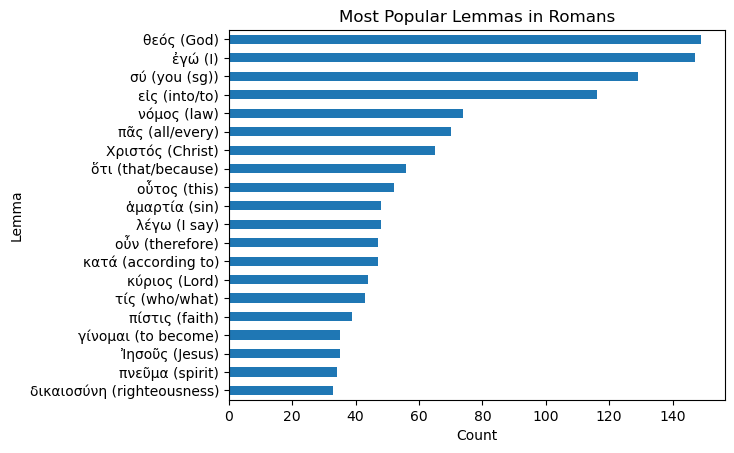

In [7]:
# Unfiltered Lemma Counts
lemma_counts = df['Lemma'].value_counts().sort_values(ascending=False)

# Filtered Lemma Counts
lemma_counts_filtered = df[~df['Lemma'].isin(greek_stopwords)]['Lemma'].value_counts().sort_values(ascending=False)

top_lemmas = lemma_counts_filtered[:20]

# Set the indices of the series to the Greek/English Pair
top_lemmas.index = [f'{lemma} ({lemma_glosses.get(lemma, "?")})' for lemma in top_lemmas.index]

top_lemmas.sort_values(ascending=True).plot(kind='barh')

plt.title('Most Popular Lemmas in Romans')
plt.xlabel("Count")
plt.ylabel("Lemma")
plt.show()


## Part of Speech Frequency

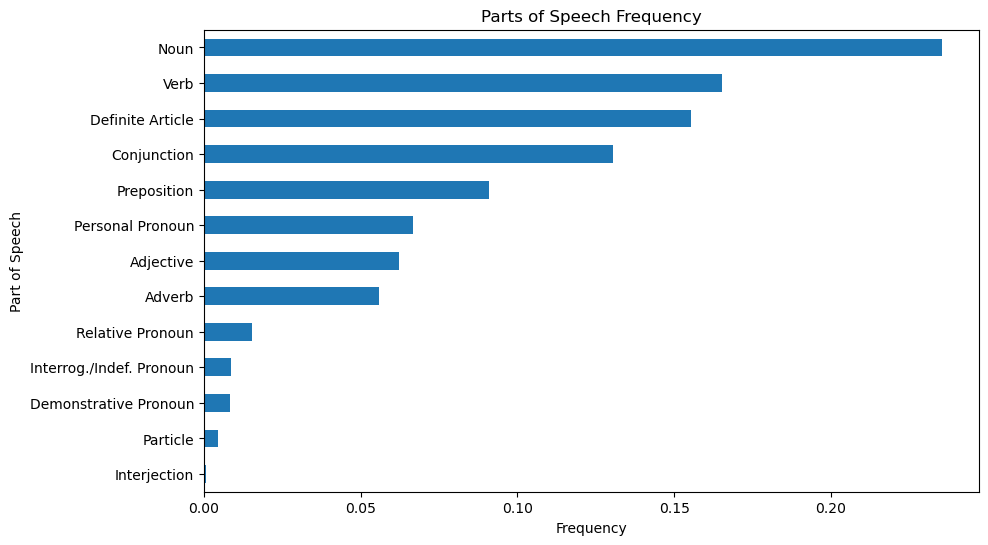

In [8]:
# Similar to the lemma counts...

pos_counts = df['Part_Of_Speech'].value_counts()
pos_counts.index = [pos_map.get(tag, tag) for tag in pos_counts.index]

pos_frequencies = pos_counts / pos_counts.sum()

pos_frequencies.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))

plt.title('Parts of Speech Frequency')
plt.xlabel('Frequency')
plt.ylabel('Part of Speech')
plt.show()

## Verbal Profile

In [9]:
df_verbs = df[df['Part_Of_Speech'] == 'V-'].copy()

### Subjunctive Purpose Clauses

The purpose of this section is to find the subjunctives form with ἵνα (hina) + subjunctive. 

The construction is:

    - ἵνα (so that, in order that) + *verb in the subjunctive mood

This is one of Paul's go-to structures for expressing:

    - Purpose (“so that sin might be shown…”)
    - Result (“in order that we might be justified…”)
    - Sometimes divine intention or theological consequences

In this way, we will isolate ἵνα as a function word, match it with verbs marked as a subjunctive mood, and filter results based on co-occurence in the same verse.

The benefit is that we will have a mini-corpus of Paul's purpose clause constructions that we can use for further analysis.

In [27]:
hina_df = df[df['Word'] == 'ἵνα']
subjunctive_df = df_verbs[df_verbs['Mood'] == 'S']
verses = df.groupby('Book_Chapter_Verse')

results = []

for _, hina_row in hina_df.iterrows():
  verse_ref = hina_row['Book_Chapter_Verse'] # Get the verse containing the hina
  verse_words = verses.get_group(verse_ref) # Get all the words for the verse with the hina
  subj_verbs = subjunctive_df[subjunctive_df['Book_Chapter_Verse'] == verse_ref] # Get the subjuntive verbs from the verse with the hina, if any

  # construct a list of dicts for each occurrence of hina + subjunctive verbs in a verse
  if not subj_verbs.empty:
    results.append({
      "Reference": verse_ref,
      "Greek_Text": ' '.join(verse_words["Text"]),
      "Subjunctive_Verbs": ', '.join(subj_verbs['Text'].unique())
    })

results_df = pd.DataFrame(results)

### Instances of μὴ γένοιτο

This is a signature Pauline phrase. It translates to "By no means!", "May it never be!" or "God forbid!". Let's find out when, how, and how many times it occurs in Romans

In [29]:
may_df = df[df['Word'] == 'μὴ']
verses = df.groupby('Book_Chapter_Verse')

results = []

for i, row in may_df.iterrows():
  verse_ref = row['Book_Chapter_Verse']
  verse_words = verses.get_group(verse_ref)
  if i+1 < df.shape[0] and df.iloc[i+1]['Word'] == 'γένοιτο':
    results.append({
      "Reference": verse_ref,
      "Greek_Text": ' '.join(verse_words['Text']),
      "Gehnoytoh_Mood": df.iloc[i+1]['Mood']
    })

results_df = pd.DataFrame(results)

### Tense and Voice Distribution

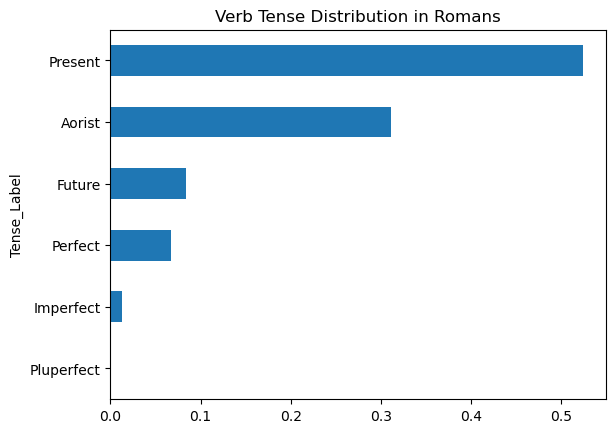

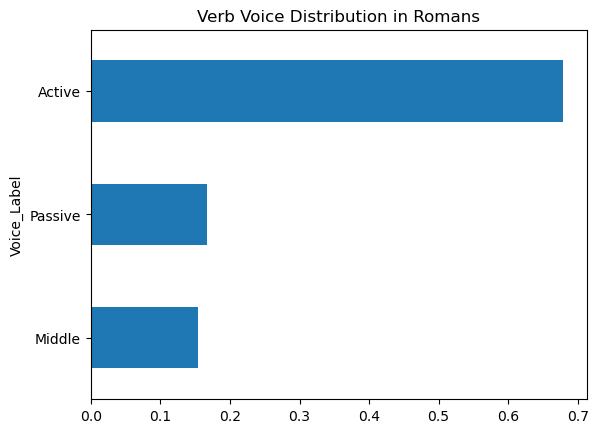

In [12]:
df_verbs['Tense_Label'].value_counts(normalize=True).sort_values().plot(
    kind='barh', title='Verb Tense Distribution in Romans')

plt.show()

df_verbs['Voice_Label'].value_counts(normalize=True).sort_values().plot(
    kind='barh', title='Verb Voice Distribution in Romans')

plt.show()

## Pronoun Profile

<Axes: title={'center': 'Pronoun Proportions'}, ylabel='Lemma'>

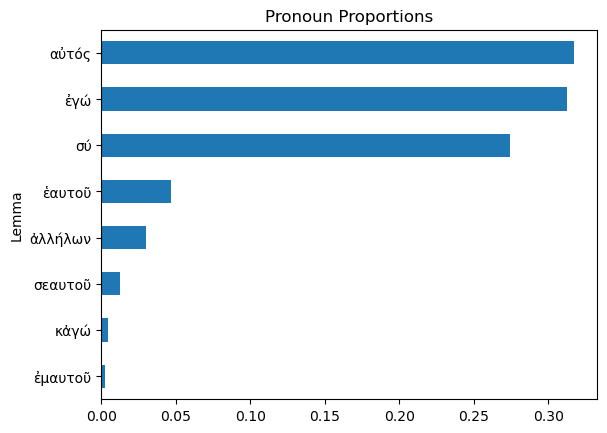

In [13]:
df_pronouns = df[df['Part_Of_Speech'] == 'RP']
df_pronouns["Lemma"].value_counts(normalize=True).sort_values().plot(kind="barh", title="Pronoun Proportions")

## N-Gram Distribution

In [14]:
def get_grams(df: pd.DataFrame, n: int):
  words = df['Text'].to_list()
  grams = list(ngrams(words, n))
  return [gram for gram in grams if all(w not in greek_stopwords for w in gram)]

In [15]:
def visualize_top_grams(grams: list, top_common: int):
  gram_counts = Counter(grams).most_common(top_common)
  grams_df = pd.DataFrame()
  grams_df['N_Gram'] = [' '.join(list(gram[0])) for gram in gram_counts]
  grams_df['N_Gram_Count'] = [gram[1] for gram in gram_counts]
  grams_df.sort_values(by=["N_Gram_Count"], inplace=True)

  plt.figure(figsize=(10,6))
  plt.barh(grams_df['N_Gram'], grams_df['N_Gram_Count'])
  plt.title(f'Top {top_common} {len(grams_df.iloc[0, 0].split())}-grams')
  plt.show()



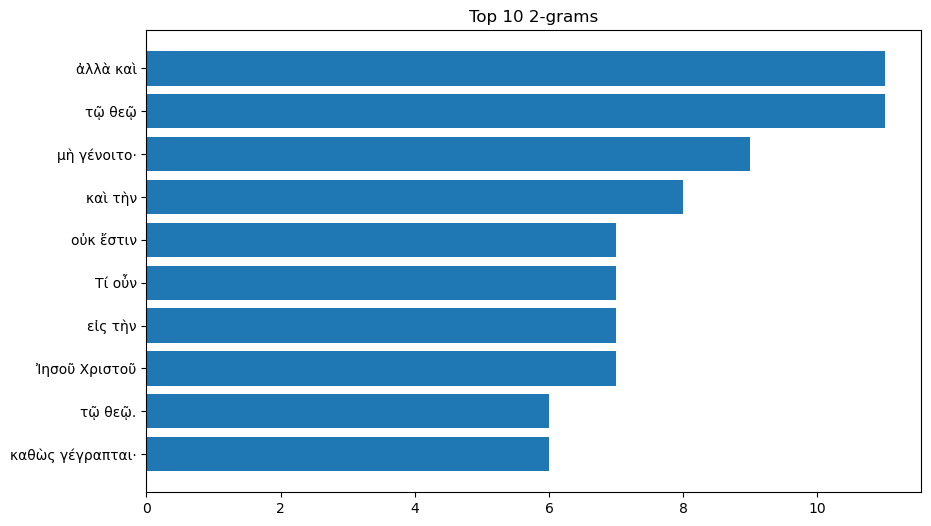

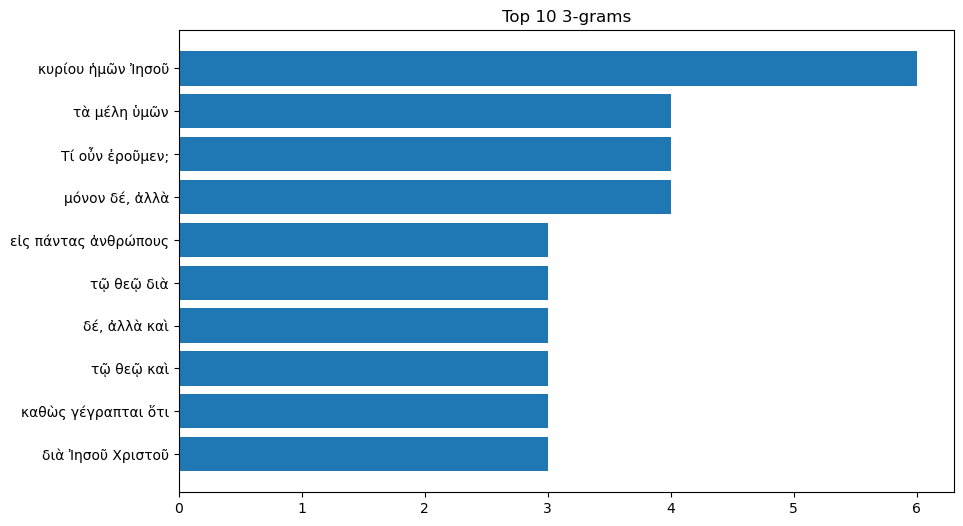

In [16]:
bigrams = get_grams(df, 2)
trigrams = get_grams(df, 3)

visualize_top_grams(bigrams, 10)
visualize_top_grams(trigrams, 10)

## Sentence Complexity

First, we'll look at sentence lengths to understand the typical lengths and distribution. Next, we'll cross-analyze with verb count to determine whether Paul's sentences are verb-rich, indicating dynamic argument in motion, or verb-sparse, indicating theological density without syntactic propulsion

### Sentence Length

In [17]:
token_counts = df.groupby('Book_Chapter_Verse')['Word'].count()
token_counts.describe()

count    430.000000
mean      16.404651
std        5.957032
min        4.000000
25%       12.000000
50%       16.000000
75%       21.000000
max       39.000000
Name: Word, dtype: float64

## Verb Density

In [18]:
verbs_mask = df['Part_Of_Speech'].str.startswith('V')
verb_counts = df[verbs_mask].groupby('Book_Chapter_Verse')['Word'].count()

complexity_df = pd.DataFrame()
complexity_df['Tokens'] = token_counts
complexity_df['Verbs'] = verb_counts
complexity_df.fillna(0, inplace=True)
complexity_df['Verb_Density'] = complexity_df['Verbs'] / complexity_df['Tokens'] * 100

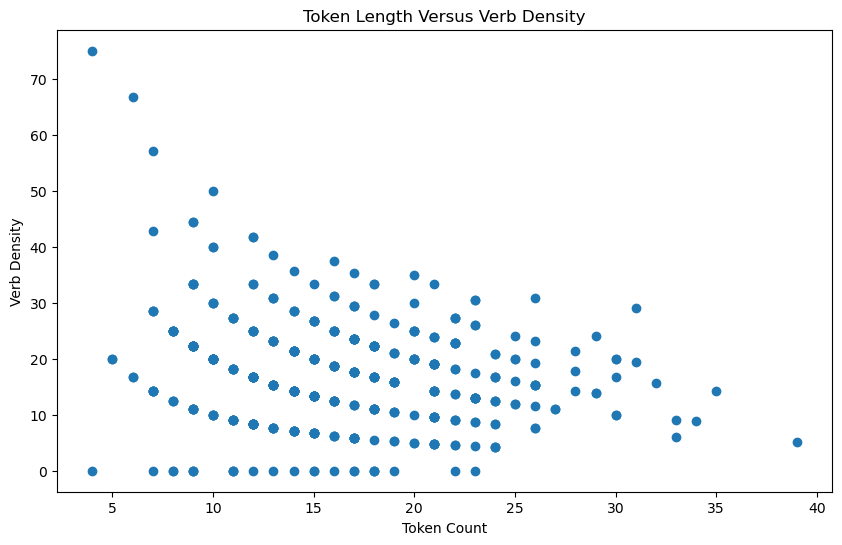

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(complexity_df['Tokens'], complexity_df['Verb_Density'])
plt.title('Token Length Versus Verb Density')
plt.xlabel('Token Count')
plt.ylabel('Verb Density')
plt.show()


### Dominant Mood by Verse

In [20]:
mood_by_verse = df[verbs_mask].groupby("Book_Chapter_Verse")['Mood'].agg(lambda x: x.value_counts().idxmax())
complexity_df['Dominant_Mood'] = mood_by_verse
complexity_df['Dominant_Mood'] = complexity_df['Dominant_Mood'].fillna('None')

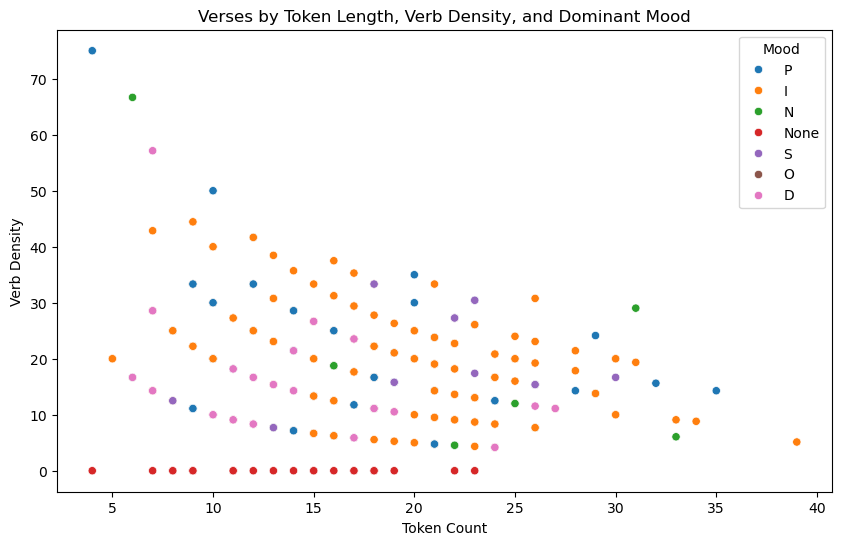

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=complexity_df, x="Tokens", y="Verb_Density", hue="Dominant_Mood")
plt.title('Verses by Token Length, Verb Density, and Dominant Mood')
plt.xlabel("Token Count")
plt.ylabel("Verb Density")
plt.legend(title="Mood")
plt.show()

### Dominant Tense by Verse

In [22]:
tense_by_verse = df[verbs_mask].groupby("Book_Chapter_Verse")['Tense'].agg(lambda x: x.value_counts().idxmax())
complexity_df['Dominant_Tense'] = tense_by_verse
complexity_df['Dominant_Tense'] = complexity_df['Dominant_Tense'].fillna("None")

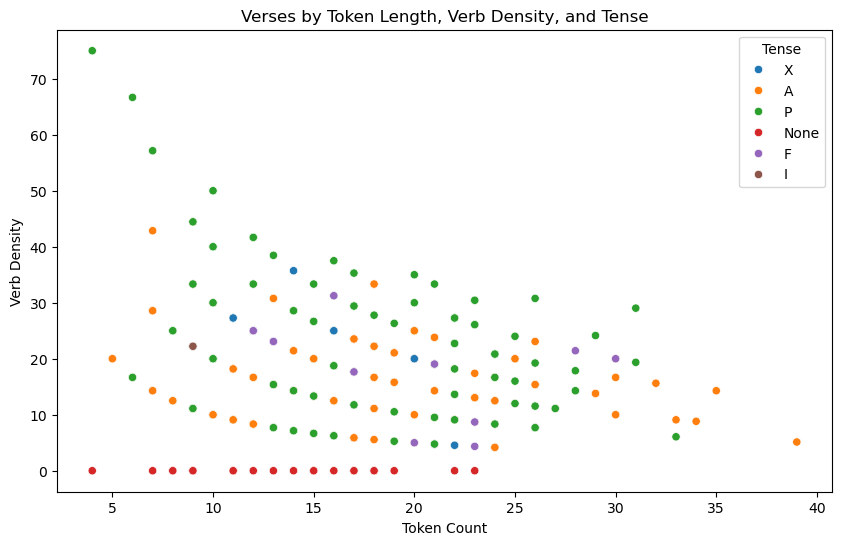

In [23]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=complexity_df, x="Tokens", y="Verb_Density", hue="Dominant_Tense")
plt.title("Verses by Token Length, Verb Density, and Tense")
plt.xlabel("Token Count")
plt.ylabel("Verb Density")
plt.legend(title="Tense")
plt.show()

### Verb Density by Chapter

In [24]:
df['Chapter'] = df['Book_Chapter_Verse'].apply(lambda x: (x // 100) % 100)

token_counts = df.groupby('Chapter')['Word'].count()
verbs_mask = df['Part_Of_Speech'].str.startswith('V')
verb_counts = df[verbs_mask].groupby("Chapter")['Word'].count()

complexity_df = pd.DataFrame()
complexity_df['Tokens'] = token_counts
complexity_df['Verbs'] = verb_counts
complexity_df.fillna(0, inplace=True)
complexity_df['Verb_Density'] = complexity_df['Verbs'] / complexity_df['Tokens'] * 100


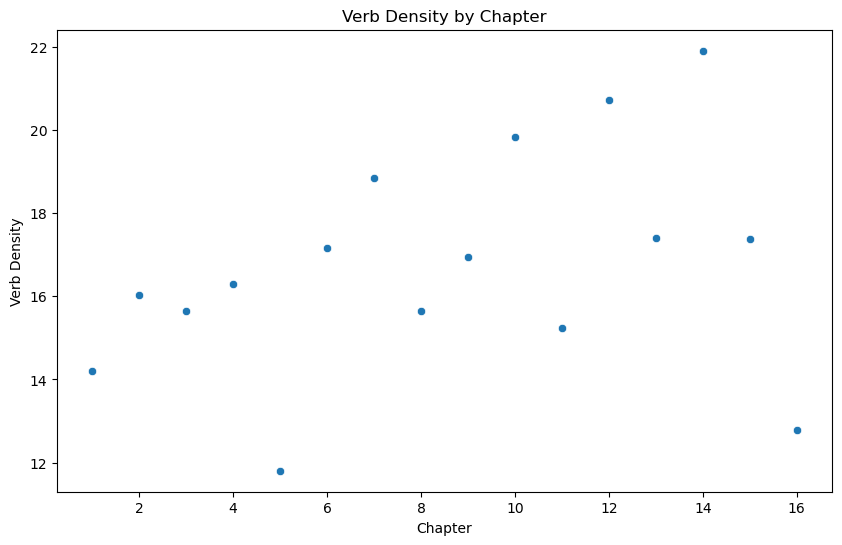

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=complexity_df, x="Chapter", y="Verb_Density")
plt.title("Verb Density by Chapter")
plt.xlabel("Chapter")
plt.ylabel("Verb Density")
plt.show()